# CatGO Tutorial

This tutorial will illustrate the basic workflow of CatGO using visual data from CIFAR-10.

To run this tutorial, you will need the following dependencies:

- Python 3
- Numpy
- Scipy
- Matplotlib

All of which should be included in a standard scientific Python distribution.

We first create a symbolic link pointing to the library. You will need to change the destination if your code sits in a different directory. 

In [ ]:
! ln -s ../ CatGO

Now we can import CatGO and other dependencies:

In [2]:
from CatGO import categorize

import numpy as np
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt

%matplotlib inline

### CIFAR-10 Data

CIFAR-10 is an image database containing 32x32 images belonging to 10 categories. We will use a subset of the data to do a quick illustration. The pre-processed data is already included in the tutorial repository.

In [3]:
cifar_data = np.load('vision-data-processed.npz')

X_train = cifar_data['X_train']
Y_train = cifar_data['Y_train']

X_test = cifar_data['X_test']
Y_test = cifar_data['Y_test']

label_set = [s.decode('UTF-8') for s in cifar_data['label_set']]

The training set contains 2000 images, and the test set contains 200.

Each image is represented as its grayscale pixel values, each flattened to an array of size 32x32=1024.

In [4]:
X_train.shape

(2000, 1024)

Here's an example image from the data:

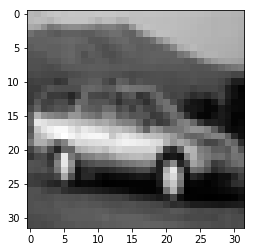

In [5]:
plt.imshow(X_train[4].reshape((32,32)), cmap='gray')

The set of 10 labels (categories) the images belong to:

In [6]:
label_set

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

The label arrays simply indexes the set array shown above.

In [7]:
Y_train[:30]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3,
       6, 6, 2, 6, 3, 5, 4, 0])

Distribution of the categories, in both sets:

In [8]:
[np.sum(Y_train==i) for i in range(10)]

[202, 191, 203, 195, 214, 183, 207, 199, 203, 203]

In [9]:
[np.sum(Y_test==i) for i in range(10)]

[20, 14, 21, 19, 15, 18, 26, 18, 28, 21]

### Setting up the Categorization Problem

To run a categorization model, you'll need the following input:

- A set of **categories**.
- **Exemplars** for each of the categories.
- A set of **stimuli** to be queried.
- **Category labels** for the queried stimuli.

In this case, the set of categories is simply the set of image labels.

In [10]:
categories = label_set

We use the 2000 image training set as our set of exemplars. Here, we rearrage the exemplars into an array, where the n'th element contains an array for all images belonging to the n'th category.

In [11]:
exemplars = np.asarray([X_train[Y_train==i] for i in range(len(label_set))])

The 200 image test set will be used as the set of visual stimuli to be queried. Furthermore, half of it will be used to fit the categoriztion models (i.e. train the models) while the rest will be unseen during training and be used to evaluate the models.

In [12]:
queries = X_test
query_labels = Y_test

#### Collaborative Filtering

CatGO also allows the use the collaboratively filtered models (See [Sun et al. 19](http://www.cs.toronto.edu/~zheweisun/files/cogsci19_slang.pdf) for detail), where we leverage knowledge from category similarities by postulating that similar categories would have similar exemplars.

This is particular useful in language applications where we have many categories but few exemplars in each. We'll apply this to visual data here to illustrate the workflow.

Here, we simply take the word embeddings for each category name to estimate their similarities.

In [13]:
word_embed = np.load('word_embed.npy')
cf_feature = dist.squareform(dist.pdist(word_embed))

You should get a matrix of distances as shown below. In general, this matrix should contain similarity scores (lower is better) for all pairs of categories.

In [14]:
cf_feature

array([[0.        , 0.6078411 , 1.1694755 , 1.50974016, 1.43959437,
        1.45714792, 1.3281681 , 1.07810621, 1.10870257, 0.93613922],
       [0.6078411 , 0.        , 1.28805677, 1.51195303, 1.36810347,
        1.45789645, 1.37238434, 1.03185527, 1.20577848, 0.85135229],
       [1.1694755 , 1.28805677, 0.        , 1.41997655, 1.37222504,
        1.44740844, 1.31683742, 1.28282671, 1.52519927, 1.39708561],
       [1.50974016, 1.51195303, 1.41997655, 0.        , 1.58276705,
        1.04595498, 1.50200914, 1.44652615, 1.74462998, 1.52457386],
       [1.43959437, 1.36810347, 1.37222504, 1.58276705, 0.        ,
        1.51293476, 1.54061003, 1.36457592, 1.71209336, 1.37926394],
       [1.45714792, 1.45789645, 1.44740844, 1.04595498, 1.51293476,
        0.        , 1.5945899 , 1.29958853, 1.68258459, 1.43948243],
       [1.3281681 , 1.37238434, 1.31683742, 1.50200914, 1.54061003,
        1.5945899 , 0.        , 1.37077544, 1.61957943, 1.44413471],
       [1.07810621, 1.03185527, 1.2828267

CatGO supports multiple feature maps for collaborative filtering when stacked matricies are passed in. Here, we will only use one feature map.

In [15]:
cf_feature = cf_feature[np.newaxis,:,:]

In [16]:
cf_feature.shape

(1, 10, 10)

### Running CatGO

First, create a *Categorizer* object by passing in the input:

In [17]:
categorizer = categorize.Categorizer(categories, exemplars, cf_feature)

CatGO allows custom indices for the queried stimuli set for training-testing split. This can be leveraged to perform random data sampling and cross validation. Here, we simply take the first half of the CIFAR-10 test set as our training data for parameter estimation, and the latter half for evaluation.

In [18]:
categorizer.set_inds(np.arange(100), np.arange(100,200))

Create a directory to store the results, and link it to CatGO using *set_datadir*. Please **make sure the directory exists** before running the optimization step.

In [19]:
! mkdir results

In [18]:
categorizer.set_datadir('results/')

We will first run CatGO on the 3 simple models. For a full list of supported models, see the documentation on github.

In [19]:
models_basic = ['onenn', 'exemplar', 'prototype']

The *run_categorization* command will optimize the kernel parameters using the training queries, and store the results in the directory specified above.

We will train the categorization model using the first half of the dataset:

In [24]:
categorizer.run_categorization(queries[:100], query_labels[:100], models_basic, mode='train', prior='uniform')

Pre-processing Distances...


100%|██████████| 10/10 [00:00<00:00, 12.23it/s]


Pre-processing Complete!
Optimizing Kernels...


100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


Once the models have been trained, we then test them using the second half of the dataset.

Running *run_categorization* with a *mode* parameter other than *'train'* will load saved parameters instead of  optimizing the parameters.

In [25]:
categorizer.run_categorization(queries[100:], query_labels[100:], models_basic, mode='test', prior='uniform')

Pre-processing Distances...


100%|██████████| 10/10 [00:00<00:00, 12.07it/s]


Pre-processing Complete!
Optimizing Kernels...


100%|██████████| 3/3 [00:00<00:00, 89.19it/s]


At this point, you've successfully performed categorization on the data! The full likelihood results are stored in the directory specified earlier (in this case, results/).

CatGO also has a built-in function *summarize_results* that computes common evaluation metrics.

We do this for both the training and test splits:

In [26]:
categorizer.summarize_results(query_labels[:100], models_basic, mode='train', prior='uniform')

[RANDOM]
Log_Likelihood (train): 230.25850929940455
AUC (train): 0.5
Expected_Rank (train): 5.0
[ONENN]
Log_Likelihood (train): 226.72782058366982
AUC (train): 0.6281818181818182
Expected_Rank (train): 4.09
[EXEMPLAR]
Log_Likelihood (train): 222.5514013653867
AUC (train): 0.6400000000000001
Expected_Rank (train): 3.96
[PROTOTYPE]
Log_Likelihood (train): 206.94884349404063
AUC (train): 0.6718181818181818
Expected_Rank (train): 3.61


In [27]:
categorizer.summarize_results(query_labels[100:], models_basic, mode='test', prior='uniform')

[RANDOM]
Log_Likelihood (test): 230.25850929940455
AUC (test): 0.5
Expected_Rank (test): 5.0
[ONENN]
Log_Likelihood (test): 227.73165977762193
AUC (test): 0.6045454545454545
Expected_Rank (test): 4.35
[EXEMPLAR]
Log_Likelihood (test): 224.66508341878486
AUC (test): 0.6227272727272728
Expected_Rank (test): 4.15
[PROTOTYPE]
Log_Likelihood (test): 220.94990267195763
AUC (test): 0.6145454545454545
Expected_Rank (test): 4.24


We can also obtain the detailed results by calling *compute_metrics* and then visualize the results:

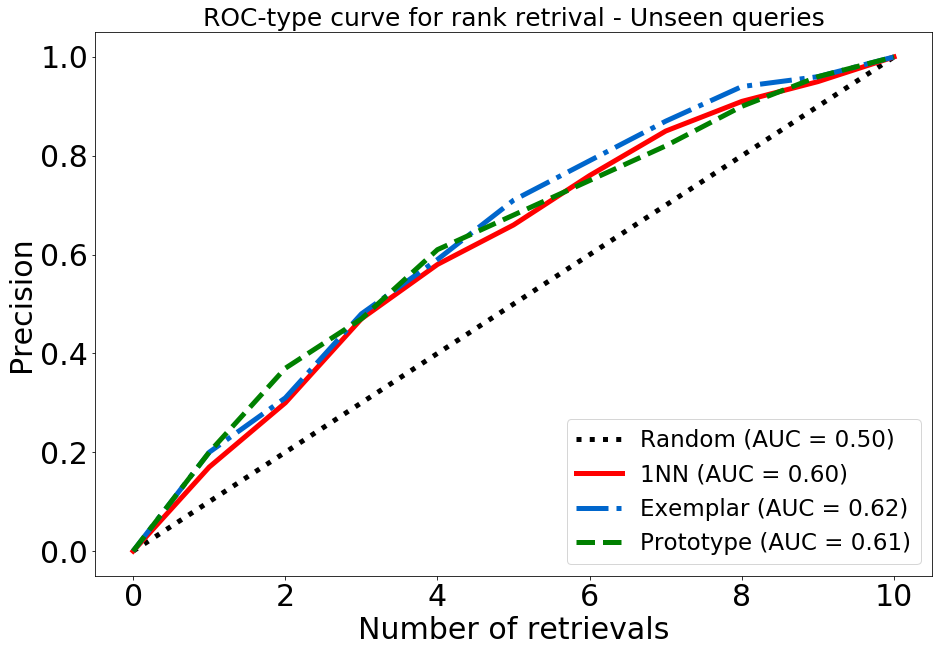

In [28]:
results = categorizer.compute_metrics(query_labels[100:], models_basic, mode='test', prior='uniform')

ax = plt.figure(figsize=(15,10))
linewidth=5

plt.plot(results['random']['roc'], label="Random (AUC = %.2f)" % np.mean(results['random']['roc']), color='black', linestyle=':', linewidth=linewidth)
plt.plot(results['onenn']['roc'], label="1NN (AUC = %.2f)" % np.mean(results['onenn']['roc']), color='red', linestyle='-', linewidth=linewidth)
plt.plot(results['exemplar']['roc'], label="Exemplar (AUC = %.2f)" % np.mean(results['exemplar']['roc']), color=(0,0.4,0.8), linestyle='-.', linewidth=linewidth)
plt.plot(results['prototype']['roc'], label="Prototype (AUC = %.2f)" % np.mean(results['prototype']['roc']), color='green', linestyle='--', linewidth=linewidth)

plt.ylabel('Precision', fontsize=30)
plt.xlabel("Number of retrievals", fontsize=30)
plt.title("ROC-type curve for rank retrival - Unseen queries", fontsize=25)
plt.legend(loc="lower right", prop={'size': 23})
plt.tick_params(labelsize=30) 
plt.show()

We see that all three models substantially outperform chance while the exemplar model is slightly better than the other two.

#### Collaborative Filtering

Now, let's try running the collaborativly filtered models:

In [29]:
models_cf = ['cf_onenn_1', 'cf_onenn_2', 'cf_exemplar_1', 'cf_exemplar_2', 'cf_prototype_1', 'cf_prototype_2']

The CF models are a bit slower to run, so let's run them in parallel! The *run_categorization_batch* command will execute serveral kernel optimizations in parallel:

In [30]:
categorizer.run_categorization_batch(queries[:100], query_labels[:100], models_cf, mode='train', prior='uniform')

Pre-processing Distances...


100%|██████████| 10/10 [00:00<00:00, 18.94it/s]


Pre-processing Complete!
Optimizing Kernels...


100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


In [31]:
categorizer.run_categorization_batch(queries[100:], query_labels[100:], models_cf, mode='test', prior='uniform')

Pre-processing Distances...


100%|██████████| 10/10 [00:00<00:00, 17.23it/s]


Pre-processing Complete!
Optimizing Kernels...


100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Results can be viewed similar to the previous set of models. Here, we do not observe an increase in performance due to the discrepency between visual and semantic domains. For instance, two types of animals may be semantically similar becuase they're in the same taxonomy but may not look similar in the visual domain.

In [32]:
categorizer.summarize_results(query_labels[:100], models_cf, mode='train', prior='uniform')

[RANDOM]
Log_Likelihood (train): 230.25850929940455
AUC (train): 0.5
Expected_Rank (train): 5.0
[CF_ONENN_1]
Log_Likelihood (train): 221.12124095808673
AUC (train): 0.6281818181818182
Expected_Rank (train): 4.09
[CF_ONENN_2]
Log_Likelihood (train): 228.2850527645427
AUC (train): 0.6272727272727273
Expected_Rank (train): 4.1
[CF_EXEMPLAR_1]
Log_Likelihood (train): 210.30687949861954
AUC (train): 0.6309090909090909
Expected_Rank (train): 4.06
[CF_EXEMPLAR_2]
Log_Likelihood (train): 226.42527565012773
AUC (train): 0.6436363636363636
Expected_Rank (train): 3.92
[CF_PROTOTYPE_1]
Log_Likelihood (train): 205.9747063889351
AUC (train): 0.660909090909091
Expected_Rank (train): 3.73
[CF_PROTOTYPE_2]
Log_Likelihood (train): 205.52826473438137
AUC (train): 0.6518181818181819
Expected_Rank (train): 3.83


In [33]:
categorizer.summarize_results(query_labels[100:], models_cf, mode='test', prior='uniform')

[RANDOM]
Log_Likelihood (test): 230.25850929940455
AUC (test): 0.5
Expected_Rank (test): 5.0
[CF_ONENN_1]
Log_Likelihood (test): 224.06785446236754
AUC (test): 0.6045454545454545
Expected_Rank (test): 4.35
[CF_ONENN_2]
Log_Likelihood (test): 229.14357448285097
AUC (test): 0.5681818181818182
Expected_Rank (test): 4.75
[CF_EXEMPLAR_1]
Log_Likelihood (test): 215.35253552375315
AUC (test): 0.6245454545454545
Expected_Rank (test): 4.13
[CF_EXEMPLAR_2]
Log_Likelihood (test): 227.79918176508747
AUC (test): 0.5990909090909091
Expected_Rank (test): 4.41
[CF_PROTOTYPE_1]
Log_Likelihood (test): 222.9834939242439
AUC (test): 0.6054545454545455
Expected_Rank (test): 4.34
[CF_PROTOTYPE_2]
Log_Likelihood (test): 223.72260647213525
AUC (test): 0.6099999999999999
Expected_Rank (test): 4.29
